In [184]:
# Essential Libraries
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer,  precision_score,  recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from collections import Counter 
from collections import defaultdict
# Initialize JavaScript for SHAP visualizations
shap.initjs()

#### Borda Scoial Choice for Selecting top 3 common features of soil

In [314]:
def borda_count_top3(*ranked_lists):
    # Assume each list is a voter's ranked preferences (highest to lowest)
    scores = defaultdict(int)
    
    for voter_list in ranked_lists:
        n = len(voter_list)
        for rank, candidate in enumerate(voter_list):
            # Top candidate gets n points, next gets n-1, ..., last gets 1
            scores[candidate] += n - rank
    
    # Print final aggregate scores
    print("Final aggregate scores:")
    for candidate, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{candidate}: {score}")
    
    # Sort candidates by total score, descending
    sorted_candidates = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    # Return top 3 candidates
    return [candidate for candidate, score in sorted_candidates[:3]]

############## SHAP #####################
#### For Aviti, Soil, RandomForest #####
# list1 = ['Roseimaritima',"Croceibacterium","SWB02","Fermentimonas","Hyphomicrobium",
#     "Planctopirus","Azotobacter","Ideonella","Spirochaeta 2","Candidatus Solibacter",
#     "Oligoflexus" ,"Ureibacillus"]
# list2 = ["SWB02","Roseimaritima","Croceibacterium","Ideonella", "Hyphomicrobium",
#     "Fermentimonas","Planctopirus","Azotobacter","Candidatus Solibacter","Spirochaeta 2",
#     "Oligoflexus","Ureibacillus"]
# list3 = ["Ideonella","Planctopirus","Azotobacter","Roseimaritima","SWB02","Croceibacterium",
#             "Fermentimonas","Hyphomicrobium","Spirochaeta 2","Candidatus Solibacter","Oligoflexus"
#              ,"Ureibacillus"]
#### For Miseq, Soil, RandomForest #####
# list1 = ["Croceibacterium","CL500-3","Dokdonella","SWB02","Gemmata","Arsenicitalea","Sphingorhabdus"
#     ,"Bradyrhizobium","Pseudomonas","Shinella","Acidibacter"]
# list2 = ["SWB02","Pseudomonas","Arsenicitalea","Croceibacterium","Dokdonella","CL500-3","Sphingorhabdus",
#          "Gemmata","Shinella","Bradyrhizobium","Acidibacter"]
# list3 = ["Sphingorhabdus","Shinella","SWB02","Pseudomonas","CL500-3","Acidibacter","Dokdonella",
# "Croceibacterium","Gemmata","Arsenicitalea","Bradyrhizobium"]
#### For Novaseq, Soil, RandomForest #####
# list1 = ["Ketobacter","Candidatus Berkiella", "Plot4-2H12","Inhella", "Rhodopila","Runella","IS-44",
# "Subgroup 10","Bauldia","Hydrogenispora","Dyadobacter","Brevifollis","Ruminofilibacter"]
# list2 = ["Inhella","Plot4-2H12","Candidatus Berkiella","Ketobacter","Runella","Rhodopila","Bauldia",
# "Subgroup 10","Dyadobacter","IS-44","Brevifollis","Hydrogenispora","Ruminofilibacter"]
# list3 = ["Inhella","Plot4-2H12","Runella","Candidatus Berkiella","Rhodopila","Ketobacter","Bauldia",
# "Subgroup 10","Dyadobacter","Brevifollis","IS-44","Ruminofilibacter","Hydrogenispora"]

#### For Aviti, Soil, LSVM #####
# list1 = ["SWB02","Croceibacterium","Opitutus","Gemmata","Hyphomicrobium","Fimbriiglobus","Cellvibrio","YC-ZSS-LKJ147",
# "BIyi10","Candidatus Solibacter","Agrobacterium","Streptomyces","Ideonella","Acidovorax","Polycyclovorans","Spirochaeta 2"]
# list2 = ["SWB02", "Gemmata", "Polycyclovorans", "Croceibacterium", "Ideonella","Streptomyces","Opitutus", "Hyphomicrobium",
# "Fimbriiglobus", "BIyi10", "Agrobacterium", "Candidatus Solibacter","Cellvibrio", "Spirochaeta 2","Acidovorax","YC-ZSS-LKJ147"]
# list3 = ["SWB02", "Ideonella", "Opitutus", "Polycyclovorans","Gemmata", "Hyphomicrobium","YC-ZSS-LKJ147", "Streptomyces",
# "Croceibacterium", "Agrobacterium", "Acidovorax", "Cellvibrio","BIyi10", "Candidatus Solibacter", "Fimbriiglobus", "Spirochaeta 2"]
#### For Miseq, Soil, LSVM #####
# list1 = ["SWB02","Pseudomonas","Steroidobacter","Acidibacter","Ellin6067","Polycyclovorans","Luteolibacter","MND1"]
# list2 = ["Steroidobacter","Pseudomonas","Acidibacter", "SWB02","Luteolibacter","Ellin6067","MND1","Polycyclovorans"]
# list3 = ["SWB02", "Pseudomonas", "Acidibacter", "Steroidobacter", "Luteolibacter","Ellin6067","Polycyclovorans","MND1"]
#### For Novaseq, Soil, LSVM #####
# list1 = ["Subgroup 10", "Fimbriiglobus", "Bauldia", "BIyi10", "IS-44",
# "Candidatus Berkiella", "Ketobacter", "Arenimonas", "Ferribacterium",
# "Pararhizobium", "Afipia", "Dyadobacter", "DSSD61", "Dechloromonas","Hydrogenispora", "Inhella"]
# list2 = ["Fimbriiglobus", "Subgroup 10", "Dechloromonas", "IS-44", "BIyi10",
# "Inhella", "Arenimonas", "Pararhizobium", "Bauldia", "Candidatus Berkiella",
# "DSSD61", "Ferribacterium", "Dyadobacter", "Hydrogenispora","Afipia", "Ketobacter"]
# list3 = ["Bauldia", "Subgroup 10", "Fimbriiglobus", "Inhella", "Pararhizobium",
# "Dechloromonas", "Arenimonas", "IS-44", "Hydrogenispora", "Dyadobacter",
# "Ferribacterium", "Candidatus Berkiella", "DSSD61", "BIyi10","Afipia", "Ketobacter"]

################ SHAPG #####################
#### For Aviti, Soil, LSVM #####
# list1=["oc32", "Chthonobacter", "Sphingorhabdus", "Planifilum", "SWB02", "BIyi10", "Candidatus Solibacter"]
# list2=["BIyi10", "SWB02", "Candidatus Solibacter","Sphingorhabdus", "Chthonobacter", "Planifilum", "oc32"]
# list3=["BIyi10","Planifilum","Chthonobacter", "SWB02", "Candidatus Solibacter","oc32", "Sphingorhabdus"]
#### For Miseq, Soil, LSVM #####
# list1= ["Dokdonella", "SWB02","Methylophilus"]
# list2 = ["SWB02", "Dokdonella","Methylophilus"]
# list3 = ["Methylophilus", "Dokdonella", "SWB02"]
#### For Novaseq, Soil, LSVM #####
# list1 = ["Methyloceanibacter", "Constrictibacter","Dyella","Plot4-2H12"]
# list2 = ["Constrictibacter", "Methyloceanibacter","Plot4-2H12","Dyella"]
# list3 = ["Plot4-2H12","Dyella", "Methyloceanibacter", "Constrictibacter"]

#### For Aviti, Soil, RF #####
# list1 = ["Pusillibacter","Planifilum", "Chthonobacter", "oc32", "SWB02", "Ideonella", "Acidovorax", "Agrobacterium", "Polycyclovorans"]
# list2 = ["Pusillibacter", "SWB02", "Acidovorax", "Chthonobacter", "Polycyclovorans","Planifilum","Ideonella", "oc32", "Agrobacterium"]
# list3 = ["oc32", "Chthonobacter", "Ideonella", "Agrobacterium","SWB02", "Polycyclovorans","Planifilum","Pusillibacter", "Acidovorax"] 
#### For Miseq, Soil, RF #####
# list1 = ["Bradyrhizobium","Ilumatobacter"]
# list2 = ["Ilumatobacter","Bradyrhizobium"]
# list3 = ["Bradyrhizobium", "Ilumatobacter"]
#### For Novaseq, Soil, RF #####
list1 = ["Plot4-2H12","Candidatus Berkiella","Runella"]
list2 = ["Plot4-2H12","Runella","Candidatus Berkiella"]
list3 =["Plot4-2H12", "Runella","Candidatus Berkiella"]
# common_elements = list(set(list1) & set(list2) & set(list3))
# print("Repeated in all three lists:", common_elements)
print(borda_count_top3(list1, list2, list3))


Repeated in all three lists: ['Candidatus Berkiella', 'Runella', 'Plot4-2H12']


#### Aim
To compare the ability of three different sequencing technologies in classifying soils of different origin (that underwent different treatments)

#### In each of the main dataset files (e.g. Aviti_raw_data.txt):
- Rows = Genus (features)
- Columns = Sample names (numbers like 1, 2, 3, ..., 36)
  
#### In the metadata/label file (Metadata.xlsx):
- First column = Sample names (but with extra characters, e.g., "T1-2", etc.)
- Second column onward = treatment/condition type (categorical label)

Genus       SM1A02  Urania-1B-19 marine sediment group     AKYG587        I-8  \
1       575.712475                           36.645015  228.549174  28.930275   
2      1019.978181                            0.000000   82.074818   0.000000   
3       483.651095                            3.430150   59.684603   0.000000   
4       810.194256                            0.000000  173.532567  20.283027   
5      1440.382926                            0.000000   76.191540   0.000000   

Genus  Ferruginibacter   Rhodoferax  Undibacterium      mle1-7  Fimbriiglobus  \
1           887.195104   242.049969       0.000000    0.000000     611.393148   
2          1654.734232   453.397180      48.980133   48.980133     413.021664   
3           832.154295   239.424443       2.744120   49.394154     921.338185   
4          1080.634619  1239.518332       0.000000  389.884857     226.493804   
5          1004.277063   899.785808       0.000000  595.745281     443.362200   

Genus         MND1  ...  V

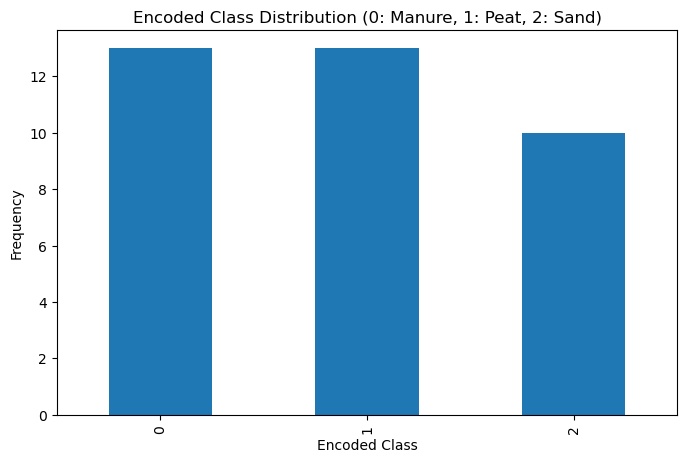

Columns with missing values: []

Number of features with 0.0 importance: 1282

Feature Importances:

X_reduced.shape is  (36, 34)

X_reduced names.shape is  34
********************
['Candidatus Berkiella', 'Runella', 'Plot4-2H12']
3
Genus  Candidatus Berkiella    Runella  Plot4-2H12
1                901.660241  13.500795   73.290030
2                888.923229   6.618937  202.539470
3                474.046676  21.266928  108.392728
4               1458.124293  11.268348   43.946559
5                502.864165  34.104785   55.148162


In [322]:
# Load and transpose the main data
##### Load Raw data (1) #####
# Aviti_raw_data (no normalization done)
# X = pd.read_csv('Aviti_raw_data.txt', delimiter='\t', index_col=0).T
# Miseq_raw_data
# X = pd.read_csv('Miseq_raw_data.txt', delimiter='\t', index_col=0).T
# Novaseq_raw_data
# X = pd.read_csv('Novaseq_raw_data.txt', delimiter='\t', index_col=0).T

##### Load Normalized data, using percentage (2) #####
# Aviti Normalized data 
# X = pd.read_csv('Aviti_perc_data.txt', delimiter='\t', index_col=0).T
# Miseq Normalized data 
# X = pd.read_csv('Miseq_perc_data.txt', delimiter='\t', index_col=0).T
# Novaseq Normalized data 
# X = pd.read_csv('Novaseq_perc_data.txt', delimiter='\t', index_col=0).T


##### Load Normalized data, using DESeq2 software (3) #####
# Aviti Normalized data 
# X = pd.read_csv('Aviti_DESeq2_normalized_data.txt', delimiter='\t', index_col=0).T
# Miseq Normalized data 
# X = pd.read_csv('Miseq_DESeq2_normalized_data.txt', delimiter='\t', index_col=0).T
# Novaseq Normalized data 
X = pd.read_csv('Novaseq_DESeq2_normalized_data.txt', delimiter='\t', index_col=0).T

print(X.head())

X.index = X.index.astype(str)

# Load metadata
metadata = pd.read_excel('Metadata.xlsx')

# Extract digits after the first 3 characters
metadata['Sample_num'] = metadata['Sample_name'].astype(str).str.slice(3).str.extract(r'(\d+)')[0]

# Create a mapping from numeric sample name → soil type
sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Soil']))
# Create a mapping from numeric sample name → Autoclave type
# sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Autoclave']))
# Create a mapping from numeric sample name → Heat root type
# sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Heat root']))

# Map sample names in X to soil types
y_raw = X.index.map(sample_to_condition)

# Keep only samples with valid labels
valid_samples = y_raw.notna()
X = X[valid_samples]
y_raw = y_raw[valid_samples]
feature_names = X.columns.tolist()
# Encode soil types
le = LabelEncoder()
y = le.fit_transform(y_raw)
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Create a DataFrame showing sample names and their labels ---> for debugging purpose
labels_df = pd.DataFrame({
    'Sample_Name': X.index,
    'Soil_Type': y_raw.values,
    'Soil_Label': y
})

# Display the result
print("🧾 Sample names with their respective labels:")
print(labels_df)



print("Encoded Class Distribution:")
print(pd.Series(y).value_counts())
# Plot the class distribution
plt.figure(figsize=(8, 5))
pd.Series(y).value_counts().plot(kind='bar')
# when condition = soil
plt.title('Encoded Class Distribution (0: Manure, 1: Peat, 2: Sand)')
#  when condition = autoclave or Heat root
# plt.title('Encoded Class Distribution (0: No, 1: Yes)')
plt.xlabel('Encoded Class')
plt.ylabel('Frequency')
plt.show()

# Check for missing values --> none
print(f"Columns with missing values: {X.columns[X.isnull().any()].tolist()}")
# Feature selection ------------------>??
rf = RandomForestClassifier(n_estimators=15, random_state=42)
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
# Count the number of features with 0.0 importance and print their names -----> only 46 is important out of 1017 when label is soil
zero_importance_features = feature_importances[feature_importances == 0.0].index.tolist()
print(f"\nNumber of features with 0.0 importance: {len(zero_importance_features)}")
# print("Features with 0.0 importance:", zero_importance_features)
print("\nFeature Importances:")
# print(feature_importances.sort_values(ascending=False))
# Remove zero importance features from X
X = X.drop(columns=zero_importance_features) 
feature_names_reduced = X.columns.tolist()
print("\nX_reduced.shape is ", X.shape)
print("\nX_reduced names.shape is ", len(feature_names_reduced))
# print(feature_names_reduced)

#//////////////////////////////// SHAPG /////////////////////////////////////////
## 😁these are the shapG features calculated from the "REDUCED Normalized FEATURES Version2"😁---> RF
#### SHAPG, Union of Aviti's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Niveispirillum', 'SWB02', 'Roseimaritima', 'BIyi10', 'Ureibacillus', 'oc32', 'Polycyclovorans', 'C1-B045', 'Methylobacter',
# 'Sneathiella', 'Ideonella', 'Spirochaeta 2', 'YC-ZSS-LKJ147', 'Fimbriiglobus', 'Acidovorax', 'Pusillibacter', 'Croceibacterium',
# 'Chthonobacter', 'Zavarzinella', 'Zhengella', 'Planifilum', 'Sphingorhabdus', 'Agrobacterium', 'Azotobacter', 'Labrys', 'Gemmata',
# 'Candidatus Solibacter', 'Parafilimonas', 'Planctopirus', 'Fermentimonas']
#### SHAPG, 3 top common features of Aviti's soil 🍳
# desired_columns = ['Chthonobacter', 'Pusillibacter', 'SWB02']
## SHAPG, Aviti Autoclave 🍕
# desired_columns = ["Rhodovarius", "Xanthomonas", "Mesobacillus", "Kaistia", "Telmatocola", "Pseudofulvimonas", "Gemmata", "Imperialibacter",
# "Chthonobacter", "Emticicia", "Niallia", "Ramlibacter", "Reyranella", "Baekduia", "UBA6140", "BBMC-4", "Conexibacter", "Bdellovibrio",
# "AKYG587", "Neobacillus"]
#### SHAPG, Aviti Heat Root 🎃
# desired_columns = ["Micropepsis", "Thermaerobacter", "Lacihabitans", "Chryseotalea", "Algoriphagus", "Spirochaeta", "Acetobacter",
# "Thermobacillus", "Candidatus Arcanobacter", "[Polyangium] brachysporum group", "Niastella", "Salinispira", "Luteibacter", "Halocella","Phreatobacter",
# "Tepidanaerobacter", "Candidatus Bealeia", "Erythrobacter", "Massilia", "Leeia"]

#### SHAPG, Union of Miseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['SWB02', 'Rubrivivax', 'Kineobactrum', 'Massilia', 'Planctomicrobium', 'Polycyclovorans', 'Ferribacterium',
# 'mle1-7', 'CL500-3', 'Sphingomonas', 'Shinella', 'Coxiella', 'Paludibaculum', 'Pseudomonas', 'Xylophilus', 'Duganella', 'Geomonas',
# 'Pirellula', 'Dechloromonas', 'OLB12', 'Luteolibacter', 'Croceibacterium', 'Bradyrhizobium', 'Methylophilus', 'Sphingorhabdus',
# 'Sphingopyxis', 'Pedomicrobium', 'Arsenicitalea', 'Gemmata', 'Methylibium', 'Asticcacaulis', 'JGI 0001001-H03', 'Dokdonella', 'Bosea',
# 'Gaiella', 'Ilumatobacter']
#### SHAPG, 3 top common features of Miseq's soil 🍳 ----> it only had 2 common features!
# desired_columns = ["Bradyrhizobium","Ilumatobacter"]
# ## SHAPG, Miseq autoclave 🍕
# desired_columns = ["mle1-7", "Imperialibacter", "Chryseotalea", "Dokdonella", "YC-ZSS-LKJ147", "Parageobacillus", "Ferruginibacter",
# "Hassallia", "Rhodoplanes", "Phenylobacterium", "Dinghuibacter", "Ilumatobacter", "Chryseolinea", "Abditibacterium", "Chthoniobacter","Bauldia",
# "Sumerlaea", "Hirschia", "Sediminibacterium", "Methylobacillus"]
#### SHAPG, Miseq Heat Root 🎃
# desired_columns = ["Cytophaga", "Spirochaeta 2", "Paludibaculum", "Tepidisphaera", "Chitinophaga", "Niastella", "Haliscomenobacter",
# "Ferruginibacter", "Chitinophaga", "Agriterribacter", "Pedobacter", "Bdellovibrio", "Pseudorhodoplanes", "Thermomonas", "Chryseotalea",
# "OLB12", "Hassallia", "Ureibacillus", "Phenylobacterium", "Luteolibacter"]


#### SHAPG, Union of Novaseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Rhodopila', 'Solimonas', 'Pararhizobium', 'BIyi10', 'Methanosarcina', 'Inhella', 'Dyella', 'Microbacterium',
# 'Ferribacterium', 'Runella', 'Ketobacter', 'Methyloceanibacter', 'Pseudarthrobacter', 'Bauldia', 'IS-44', 'Fimbriiglobus',
# 'Brevifollis', 'Plot4-2H12','DSSD61','Dechloromonas','Pusillibacter','Afipia','Cerasicoccus','Caldicoprobacter','Constrictibacter',
# 'Candidatus Berkiella', 'Ruminofilibacter', 'Dyadobacter', 'Hydrogenispora', 'Flavimaricola', 'Amaricoccus', 'Leeia']
#### SHAPG, 3 top common features of Novaseq's soil 🍳
desired_columns = ['Candidatus Berkiella', 'Runella', 'Plot4-2H12']
#### SHAPG, Novaseq autoclave 🍕
# desired_columns = ["Mesobacillus", "Brucella", "Ruficoccus", "Kribbella", "Candidatus Protochlamydia", "Gemmata",
# "Noviherbaspirillum", "Desulfovibrio", "Snodgrassella", "Ramlibacter", "Immundisolibacter", "Ammoniphilus",
# "Subgroup 10", "Papillibacter", "Altericroceibacterium", "Sorangium", "Stenotrophobacter", "Aquisphaera",
# "Dechloromonas", "Methylobacillus"]
#### SHAPG, Novaseq Heat Root 🎃
# desired_columns = ["Erythrobacter","Algoriphagus","Lachnospiraceae UCG-004","Apilactobacillus", "Diaphorobacter","Phycocomes",
# "Desulfopila", "Phragmitibacter","Bordetella", "Meiothermus", "Actinokineospora", "Geothrix", "Fundidesulfovibrio",
# "Imperialibacter", "CL500-3", "Caedibacter", "Acrocarpospora", "Rhodovastum", "Skermanella", "Gemmobacter"]

# uncomment the following line if you choose SHAP features in "desired_columns" and not al features ones.
print("********************")
print(desired_columns)
print(len(desired_columns))
X = X[desired_columns]
print(X.head())
# print(X_reduced.head())

#### Different versions of Features we tested 

In [62]:
#### Using SHAP Features instead of All features, using "unnormalized" data ---> RF
## SHAP, Union of Aviti's soil features within 3 groups (uniques only) 🍳
# # desired_columns=['Acidovorax', 'Actinoplanes','Arenibacter', 'Azotobacter','BIyi10', 'Confluentibacter', 'Croceicoccus', 
#  'Crocinitomix', 'Denitratisoma', 'Ferrovibrio', 'Flavobacterium', 'Gemmobacter','Ideonella', 'Ignavibacterium', 'Ilumatobacter',
# 'JTB255 marine benthic group','Kribbella', 'Leptothrix', 'Phreatobacter', 'Planktosalinus','Pusillibacter', 'Roseomonas',
# 'Ruminofilibacter', 'Rurimicrobium', 'Shinella', 'Sphingosinicella', 'Thermobispora']
## SHAP, Aviti Autoclave 🍕
# desired_columns=[ 'Ammoniphilus','Neobacillus','Inquilinus','Crocinitomix','Asticcacaulis','Opitutus',
#                  'Reyranella','FFCH7168','Spirochaeta 2','Achromobacter', 'Prosthecobacter','YC-ZSS-LKJ147',
#                  'Rhodoplanes', 'UTCFX1','Cephaloticoccus','Pseudoxanthobacter','Aquisphaera','Duganella','Microvirga','Bauldia']
## SHAP, Aviti Heat Root 🎃
# desired_columns=['Mesorhizobium','Mycobacterium','Taibaiella','Candidatus Nitrosoarchaeum',
# 'Cavicella','Nocardioides','Candidatus Ovatusbacter','Yinghuangia','Aggregatilinea','Sandaracinus','Caenimonas',
# 'JGI 0001001-H03','LD29','Oligoflexus','Marinoscillum','Bradyrhizobium','Archangium','Constrictibacter','Subgroup 10','Aquihabitans']
# ## # SHAP, Union of Miseq's soil features within 3 groups (uniques only) 🍳
# desired_columns= ['UBA6140','BIyi10','Candidatus Dichloromethanomonas','Opitutus', 'Gemmata','Dokdonella', 'Croceicoccus',
#     'Ilumatobacter',   'Methylobacter','Planctomicrobium',    'Bryobacter','Fuscovulum',  'SWB02','MND1', 
#     'Luteitalea','Oleiharenicola','Methylobacillus','Paludibaculum','Dongia','Bradyrhizobium', 'Permianibacter',
#     'Agrobacterium','Nitrosospira','Steroidobacter','Panacibacter','Acidibacter','Candidatus Berkiella', 'Lacibacter',
#     'Aurantisolimonas','Emticicia','Sphingorhabdus', 'Azospirillum','OLB12','Ideonella','Ferribacterium', 'Shinella']
# ## SHAP, Miseq autoclave 🍕
# desired_columns=['Methylobacillus','Devosia','Bauldia','Steroidobacter','Acidibacter',
# 'Ramlibacter','Crocinitomix','Rhodoplanes','Phaeodactylibacter','Chthoniobacter','CL500-29 marine group',
# 'Imperialibacter','Luteolibacter','Arsenicitalea','mle1-7','Croceibacterium','Phenylobacterium','Cypionkella',
# 'Aridibacter','Hirschia']
# ## SHAP, Miseq HeatRoot 🎃 
# desired_columns=['Rhodoplanes','Nemorincola','Marinoscillum','Phaeodactylibacter','Hyphomicrobium',
# 'Algoriphagus','Acidovorax','Hassallia','Pedomicrobium','OLB13','Phenylobacterium',
# 'Spirochaeta 2','Lysinibacillus','DSSD61','Fuscovulum','Pelotalea','Croceibacterium',
# 'Brevundimonas','Ohtaekwangia','Niallia']
# # SHAP, Union of Novaseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Georgfuchsia','Alcanivorax','UBA6140', 'Tahibacter','Flavimaricola', 'BIyi10', 'Rhodovastum',
#     'Agrobacterium', 'Anaerolinea', 'Sphaerobacter', 'Rhodovarius', 'Variovorax', 'Thiobacillus', 'Permianibacter',
#     'Hirschia', 'DEV008', 'Rhodoligotrophos', 'Leptospirillum', 'Syntrophus', 'Rubrivirga', 'Pedomicrobium',
#     'Micropepsis', 'Methyloversatilis', 'Planctomicrobium', 'Opitutus', 'Desulfocastanea','Sulfuricurvum', 'UBA12409', 'Muricauda']
# # ## SHAP, Novaseq autoclave 🍕
# desired_columns=['Achromobacter','Devosia','Ammoniphilus','Phaeodactylibacter','CSP1-2','Brevibacillus','Sulfuricaulis'
# ,'Niallia','Pseudoxanthobacter','Stenotrophobacter','I-8','Thermopolyspora','Faecalibacterium','Paenibacillus','Abditibacterium',
# 'Massilia','Haloplasma','Ilumatobacter','Panacagrimonas','Urania-1B-19 marine sediment group']
# ## SHAP, Novaseq HeatRoot 🎃
# desired_columns=['Abditibacterium','Noviherbaspirillum','Nocardia','Arcticibacter','Galbitalea','Methylotenera','Mariniblastus',
# 'Lentzea','Aneurinibacillus','C1-B045','Azovibrio','possible genus 04','Povalibacter','Paludibacterium','Pedobacter',
# 'Immundisolibacter','Thauera','Nemorincola','Pedosphaera','Knoellia']
# uncomment the following line if you choose SHAP features in "desired_columns" and not al features ones.
# X = X[desired_columns]
# print(X.head())
# print(X_reduced.head())

In [ ]:
## 😁these are the shap features calculated from the "REDUCED Normalized FEATURES Version1"😁 ---> RF
# ## SHAP, Union of Aviti's soil features within 3 groups (uniques only) 🍳
# desired_columns=['Methylobacter', 'Taibaiella', 'SWB02', 'Pajaroellobacter', 'Thermaerobacter', 'SM1A02',
# 'Azotobacter', 'RS25G', 'Luteolibacter', 'Roseimaritima', 'Terrimonas', 'BIyi10', 'C1-B045', 'Agrobacterium',
# 'Spirochaeta 2', 'Hyphomicrobium', 'Bryobacter', 'Sneathiella', 'Opitutus', 'Azohydromonas', 'Gemmata', 'Luteitalea',
# 'Rubrivivax', 'Spirochaeta', 'Methylophilus', 'Chthonobacter']
## SHAP, Aviti Autoclave 🍕
# desired_columns=['Mesobacillus','Niallia','IS-44','Parvibaculum','Chthoniobacter','Desulfocurvibacter'
# ,'Candidatus Ovatusbacter','Lautropia','Sulfurifustis','Sphingoaurantiacus','Chryseobacterium','YC-ZSS-LKJ147',
# 'Caulobacter','Rhodovarius','Tepidisphaera','Erythrobacter','Methylobacter','CM1G08','Tsuneonella','MND1']
## SHAP, Aviti Heat Root 🎃
# desired_columns=['Massilia','Salinispira','Reyranella','Cavicella','Roseateles','Stenotrophomonas',
# 'Aeromicrobium','Thermaerobacter','Taonella','Pseudobdellovibrio','Peredibacter','Candidatus Solibacter',
# 'Azohydromonas','Aquicella','Methyloversatilis','Abditibacterium','Ramlibacter','OLB12','Mycobacterium','Piscinibacter']
## SHAP, Union of Miseq's soil features within 3 groups (uniques only) 🍳
# desired_columns=['Paludibaculum', 'SWB02', 'Acidovorax', 'Pir4 lineage', 'Polycyclovorans', 'Croceibacterium', 'BIyi10',
# 'Methylotenera', 'OLB12', 'Hirschia', 'Bryobacter', 'Dokdonella', 'Croceicoccus', 'Opitutus', 'Bauldia', 'Dongia',
# 'Emticicia', 'Bradyrhizobium', 'Gemmata', 'Panacibacter', 'Arsenicitalea', 'MND1', 'JGI 0001001-H03', 'Steroidobacter','Methylophilus']
# ## SHAP, Miseq autoclave 🍕
# desired_columns=['Imperialibacter','Bauldia','Devosia','Methylobacillus','Ellin517','YC-ZSS-LKJ147',
# 'Opitutus','Ramlibacter','mle1-7','Rhodoplanes','Cypionkella','Phaeodactylibacter','Oleiharenicola','SM1A02',
# 'Hassallia','Spirochaeta 2','Subgroup 10','Novosphingobium','Chryseolinea','Pseudomonas']
# ## SHAP, Miseq HeatRoot 🎃
# desired_columns=['Aquicella','UBA12409','Niastella','Chryseolinea','Hassallia','Nemorincola',
# 'Acidibacter','Methylotenera','WY65','Hydrogenophaga','Ohtaekwangia','Rhodoplanes','Spirochaeta 2',
# 'MND1','Pedomicrobium','Algoriphagus','Bauldia','IS-44','Ellin517','Candidatus Ovatusbacter']
# ## SHAP, Union of Novaseq's soil features within 3 groups (uniques only) 🍳
# desired_columns=['Sva0996 marine group', 'Iamia', 'Truepera', 'Anaerolinea', 'Acidovorax', 'Solimonas', 'Hydrogenispora',
# 'Afipia', 'Thermaerobacter', 'Galbitalea', 'Roseimaritima', 'Actinotalea', 'Candidatus Berkiella', 'Ideonella', 'Pedomicrobium',
# 'BIyi10', 'OLB12', 'Hyphomicrobium', 'Inhella', 'Dyadobacter', 'Dyella', 'Pusillibacter', 'Chryseobacterium']
    # # ## SHAP, Novaseq autoclave 🍕
# desired_columns=['Neobacillus','Niallia','Pseudoxanthobacter','Parvibaculum','Phaeodactylibacter',
# 'Snodgrassella','Stenotrophobacter','Candidatus Protochlamydia','Methylocaldum','Metabacillus','Lelliottia',
# 'Kribbella','Ellin516','Morganella','Aquicella','Ellin517','Flavitalea','Dysgonomonas','Ferdinandcohnia','Spirochaeta 2']
# ## SHAP, Novaseq HeatRoot 🎃
# desired_columns=['Rhodovarius','Polyangium','Acinetobacter','Aquicella','Erythrobacter','Nocardia',
# 'Hirschia','Variovorax','Erysipelotrichaceae UCG-003','Marmoricola','Stenotrophobacter','Pseudaminobacter',
# 'Azospirillum','Spirochaeta 2','Phaeodactylibacter','Kaistia','Chryseotalea','Fimbriiglobus','Nitrosomonas','Plot4-2H12']
# uncomment the following line if you choose SHAP features in "desired_columns" and not al features ones.
# X = X[desired_columns]
# print(X.head())
# print(X_reduced.head())

In [ ]:
## 😁these are the shap features calculated from the "REDUCED Normalized FEATURES Version2"😁---> RF
#### SHAP, Union of Aviti's soil features within 3 groups (uniques only) 🍳
# desired_columns =["Acidovorax","Agrobacterium","Azotobacter","C1-B045","Candidatus Solibacter","Cellvibrio","Chthonobacter",
# "Croceibacterium","Fermentimonas","Fimbriiglobus","Hyphomicrobium","Ideonella","Labrys","Methylobacter","Niveispirillum","Oligoflexus",
# "oc32","Parafilimonas","Planctopirus","Planifilum","Roseimaritima","Sneathiella","Spirochaeta 2","SWB02","Ureibacillus","Zavarzinella"]
#### SHAP, 3 top common features of Aviti's soil 🍳
# desired_columns =["Roseimaritima","SWB02","Croceibacterium"]
## SHAP, Aviti Autoclave 🍕
# desired_columns=['Gemmata','Neobacillus','Ramlibacter','Methanosarcina','Niallia','UBA6140','Imperialibacter',
# 'OLB13','Methylobacter','Flavobacterium','Stenotrophobacter','Telmatocola','Dysgonomonas','Blastocatella',
# 'Methyloversatilis','Pseudofulvimonas','Mesobacillus','Sphingomonas','Sulfurifustis','Reyranella']
#### SHAP, Aviti Heat Root 🎃
# desired_columns = ["YC-ZSS-LKJ147","Salinispira","Massilia","Algoriphagus","Microbacterium","Candidatus Arcanobacter",
# "Reyranella","Candidatus Ovatusbacter","Rhodopila","Candidatus Omnitrophus","Erythrobacter","Mesorhizobium","Lacihabitans",
# "Variovorax","Xylophilus","Pseudoduganella","Bradyrhizobium","Ramlibacter","OLB13","Mycobacterium"]

#### SHAP, Union of Miseq's soil features within 3 groups (uniques only) 🍳
# desired_columns =["Acidibacter","Arsenicitalea","Bosea","Bradyrhizobium","CL500-3","Croceibacterium","Dechloromonas","Dokdonella",
# "Ferribacterium","Gemmata","Geomonas","Ilumatobacter","JGI 0001001-H03","Kineobactrum","Luteolibacter","MND1","Methylophilus","OLB12",
# "Oleiharenicola","Opitutus","Planctomicrobium","Pseudomonas","Rubrivivax","Shinella","Sphingopyxis","Sphingorhabdus","Steroidobacter","SWB02"]
#### SHAP, 3 top common features of Miseq's soil 🍳
# desired_columns=['SWB02', 'Croceibacterium', 'CL500-3']
# ## SHAP, Miseq autoclave 🍕
# desired_columns=['Chryseolinea','Imperialibacter','Abditibacterium','YC-ZSS-LKJ147','Rhodoplanes','Methylobacillus',
# 'Candidatus Nitrosoarchaeum','mle1-7','Bauldia','Hirschia','Devosia','Ellin6055','Ferruginibacter','IS-44','Parageobacillus',
# 'Mesobacillus','Ramlibacter','Dinghuibacter','Hassallia','Dokdonella']
#### SHAP, Miseq Heat Root 🎃
# desired_columns = ['Ilumatobacter','Pedobacter','MND1','Oleiharenicola','Phaselicystis','Chitinophaga','Chryseotalea',
# 'Pseudolabrys','Agriterribacter','Hydrogenophaga','Opitutus','Hypericibacter','Pedomicrobium','Luteolibacter',
# 'YC-ZSS-LKJ147','Subgroup 10','Candidatus Solibacter', 'Lentzea','Methylotenera','Labrys']

#### SHAP, Union of Novaseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = [
#     "Afipia", "Bauldia", "BIyi10", "Brevifollis", "Caldicoprobacter",
#     "Candidatus Berkiella", "DSSD61", "Dyadobacter", "Dyella",
#     "Hydrogenispora", "IS-44", "Inhella", "Ketobacter", "Methanosarcina",
#     "Microbacterium", "Pararhizobium", "Plot4-2H12", "Pseudarthrobacter",
#     "Rhodopila", "Ruminofilibacter", "Runella", "Solimonas", "Subgroup 10"]
#### SHAP, 3 top common features of Novaseq's soil 🍳
# desired_columns =['Inhella', 'Plot4-2H12', 'Candidatus Berkiella']
#### SHAP, Novaseq autoclave 🍕
# desired_columns=['Neobacillus','Ammoniphilus','Stenotrophobacter','Kribbella','Snodgrassella','Gemmata','BIyi10','Aminobacter',
# 'Cupriavidus','Immundisolibacter','[Aquaspirillum] arcticum group','Slackia','Noviherbaspirillum','Novosphingobium',
# 'Marinoscillum','Brevibacillus','Verrucosispora','Subgroup 10','Crocinitomix','OLB13']
#### SHAP, Novaseq Heat Root 🎃
# desired_columns = ["Algoriphagus","Kribbella","Apilactobacillus","CL500-3","Acinetobacter","Candidatus Nitrosoarchaeum",
# "Rhodovastum","Longimicrobium","Stenotrophobacter","Candidatus Omnitrophus" ,"Pararhizobium","Niallia","Noviherbaspirillum",
# "Ketobacter","Hassallia","Ferruginibacter","Aquicella","Hydrogenispora","Candidatus Xiphinematobacter","Meiothermus"]

# uncomment the following line if you choose SHAP features in "desired_columns" and not al features ones.
# X = X[desired_columns]

In [ ]:
## 😁these are the shap features calculated from the "REDUCED Normalized FEATURES Version2 ----> LSVM"😁
#### SHAP, Union of Aviti's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Azotobacter', 'Labrys', 'Chthonobacter', 'Ideonella', 'Sphingorhabdus', 'Agrobacterium', 'Acidovorax', 'YC-ZSS-LKJ147',
# 'Parafilimonas', 'Gemmata', 'Sneathiella', 'Fimbriiglobus', 'C1-B045', 'Methylobacter', 'BIyi10', 'SWB02', 'Polycyclovorans', 'Croceibacterium',
# 'Candidatus Solibacter', 'Hyphomicrobium', 'Cellvibrio', 'Spirochaeta 2', 'Streptomyces', 'Opitutus']
#### SHAP, 3 top common features of Aviti's soil, using Borda count 🍳
# desired_columns =['SWB02', 'Gemmata', 'Opitutus']
## SHAP, Aviti Autoclave 🍕
# desired_columns= ["Flavobacterium","Sphingomonas","Arenimonas","Hassallia","Methylobacter","Ramlibacter","Rubrivivax",
#     "Gemmata","Stenotrophobacter","Pelotalea","Sediminibacterium","Paucibacter","UBA6140","Iamia","Acidiferrimicrobium",
#     "Hirschia","Niastella","Pseudorhodoplanes","Reyranella","Conexibacter"]
# #### SHAP, Aviti HeatRoot 🎃
# desired_columns = ["Terrimonas","Chryseotalea","Subgroup 10" ,"MND1","Arenimonas","Ramlibacter","Bradyrhizobium",
# "Sediminibacterium","Devosia","Gemmatimonas","Cellvibrio","Ohtaekwangia","Luteolibacter","YC-ZSS-LKJ147","Ferribacterium",
# "Algoriphagus","Variovorax", "Lentzea","Rhizobacter","Massilia"]

#### SHAP, Union of Miseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Ilumatobacter', 'CL500-3', 'Ohtaekwangia','Arsenicitalea', 'Dechloromonas', 'Geomonas', 'Pirellula', 'Sphingorhabdus',
# 'Paludibaculum', 'Dokdonella', 'Ellin6067', 'Acidibacter', 'Rubrivivax', 'Gemmata', 'Pedomicrobium', 'OLB12', 'MND1', 'Sphingomonas',
# 'Pseudomonas', 'SWB02', 'Polycyclovorans', 'Croceibacterium', 'JGI 0001001-H03', 'Kineobactrum', 'Oleiharenicola', 'Steroidobacter',
# 'Methylophilus', 'Shinella', 'Opitutus', 'Luteolibacter']
#### SHAP, 3 top common features of Miseq's soil, using Borda count 🍳
# desired_columns =['SWB02', 'Pseudomonas', 'Steroidobacter']
## SHAP, Miseq Autoclave 🍕
# desired_columns = ["IS-44","Dokdonella","Methylobacillus","Candidatus Solibacter","Ferruginibacter","Chthoniobacter","Devosia",
# "Hirschia","Bauldia","Ramlibacter","Chryseotalea","Phenylobacterium","Ellin6055","YC-ZSS-LKJ147","Panacibacter","Ellin517",
# "Luteolibacter",    "Pir4 lineage",    "Rhodoplanes","mle1-7"]
#### SHAP, Miseq HeatRoot 🎃
# desired_columns = ["UBA6140","Pseudomonas","Methylotenera","Oleiharenicola","Opitutus", "Croceibacterium","Candidatus Solibacter",
# "Dongia","MND1","Steroidobacter","Ilumatobacter","YC-ZSS-LKJ147","Pirellula","Sphingomonas","Subgroup 10","Reyranella",
# "Hassallia","Phenylobacterium","Chryseotalea","Ellin6067"]

#### SHAP, Union of Novaseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Subgroup 10', 'Dyadobacter', 'Dechloromonas', 'Inhella', 'Leeia', 'Pararhizobium', 'Arenimonas', 'Plot4-2H12',
# 'Microbacterium', 'Afipia', 'Hydrogenispora', 'Fimbriiglobus', 'Constrictibacter', 'Brevifollis', 'BIyi10', 'Candidatus Berkiella',
# 'DSSD61', 'Pseudarthrobacter', 'Bauldia', 'Ferribacterium', 'IS-44', 'Methyloceanibacter', 'Ketobacter']
#### SHAP, 3 top common features of Novaseq's soil, using Borda count 🍳
# desired_columns =['Subgroup 10', 'Fimbriiglobus', 'Bauldia']
#### SHAP, Novaseq autoclave 🍕
# desired_columns =["Ramlibacter","Gemmata","BIyi10","Novosphingobium","TM7a","Methylobacillus","Pseudomonas",
# "Algoriphagus","Marinoscillum","CL500-3","Subgroup 10","Kribbella","Aminobacter","Mesobacillus","Agrobacterium",
# "Cupriavidus","Asticcacaulis","Candidatus Protochlamydia","Niallia","Neobacillus"]
#### SHAP, Novaseq HeatRoot 🎃
# desired_columns = ["Shinella","CL500-3","Novosphingobium","Hassallia","Ahniella","Aquicella","Ferruginibacter","BIyi10",
# "Curvibacter","Acinetobacter","Chryseotalea","Rhodovastum","Solirubrobacter","Anaerolinea","Aeromicrobium","Candidatus Nitrosoarchaeum",
# "Steroidobacter","Algoriphagus","Noviherbaspirillum","Candidatus Omnitrophus"]

In [ ]:
## 😁these are the shap features calculated from the "REDUCED Normalized FEATURES Version2 ----> SHAPG&LSVM"😁
#### SHAPg, Union of Aviti's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Niveispirillum', 'SWB02','Roseimaritima','BIyi10','Ureibacillus','oc32','Polycyclovorans','C1-B045',
# 'Methylobacter', 'Sneathiella', 'Ideonella', 'Spirochaeta 2', 'Fimbriiglobus', 'Cellvibrio', 'Acidovorax', 'Pusillibacter',
# 'Croceibacterium', 'Chthonobacter', 'Zavarzinella', 'Planifilum', 'Sphingorhabdus', 'Agrobacterium', 'Azotobacter','Hyphomicrobium',
# 'Labrys', 'Candidatus Solibacter', 'Gemmata', 'Parafilimonas', 'Planctopirus', 'Fermentimonas']
#### SHAPg, 3 top common features of Aviti's soil, using Borda count 🍳
# desired_columns=['BIyi10', 'Chthonobacter', 'SWB02']
## SHAPg, Aviti Autoclave 🍕
# desired_columns=["Xanthomonas","Mesobacillus","Pseudofulvimonas","Kaistia","Pusillibacter","Rhodovarius",
# "Imperialibacter","Baekduia","Methanosarcina","Aetherobacter","Pelotalea","Erythrobacter","OLB13","Hirschia",
# "BBMC-4","Niallia","Methylobacter","Niastella","Tepidisphaera","Emticicia"]
##### SHAPg, Aviti HeatRoot 🎃
# desired_columns = ["Erythrobacter","Salinispira","Acetobacter","Luteibacter","Spirochaeta","Propionicicella","Tepidanaerobacter",
# "Thermaerobacter","Leeia","[Polyangium] brachysporum group","Mycobacterium","OLB13","Lentzea","Roseateles","Sediminibacterium",
# "Lacihabitans","Candidatus Bealeia","Candidatus Ovatusbacter","Cavicella","Allocatelliglobosispora"]

#### SHAPG, Union of Miseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['SWB02', 'Rubrivivax', 'Kineobactrum', 'Planctomicrobium', 'Massilia', 'Polycyclovorans', 'Ferribacterium', 'mle1-7',
# 'CL500-3','Sphingomonas', 'Shinella', 'Coxiella', 'Paludibaculum', 'Pseudomonas', 'CL500-29 marine group', 'Geomonas',
# 'Pirellula', 'Dechloromonas', 'Luteolibacter', 'OLB12', 'Acidibacter', 'Croceibacterium', 'Bradyrhizobium', 'Aquicella',
# 'Methylophilus', 'Sphingorhabdus', 'MND1', 'Sphingopyxis', 'Pedomicrobium', 'Arsenicitalea', 'Gemmata', 'Opitutus','JGI 0001001-H03',
# 'Dokdonella', 'Bosea', 'Gaiella', 'Ilumatobacter']
#### SHAPG, 3 top common features of Miseq's soil, using Borda count 🍳
# desired_columns = ['Dokdonella', 'SWB02', 'Methylophilus']
## SHAPG, Miseq Autoclave 🍕
# desired_columns = ["Mesobacillus","mle1-7","YC-ZSS-LKJ147","Imperialibacter","Panacagrimonas","Dinghuibacter",
# "Parageobacillus","Chryseotalea","Rhodoplanes","Abditibacterium","Hassallia","Ferruginibacter","Chryseobacterium","Bauldia",
# "Chthoniobacter","Chryseolinea","Dokdonella","Lelliottia","Aquicella","Methyloceanibacter"]
#### SHAPG, Miseq HeatRoot 🎃
# desired_columns = ["Pelagibius", "YC-ZSS-LKJ147", "Methylotenera", "UBA6140", "Hydrogenophaga",
# "Pseudolabrys", "Rhodoferax", "Aetherobacter", "Pedobacter", "Phaselicystis", "Ilumatobacter","Paludibaculum",
# "Chthonobacter", "Cereibacter", "Cytophaga", "Ellin6055","Gemmobacter", "Legionella", "Ferruginibacter", "Ureibacillus"]

#### SHAPG, Union of Novaseq's soil features within 3 groups (uniques only) 🍳
# desired_columns = ['Methanosarcina', 'Solimonas', 'Pararhizobium', 'BIyi10', 'Inhella', 'Dyella', 'Microbacterium', 'Ferribacterium', 'Runella',
# 'Ketobacter','Methyloceanibacter', 'Pseudarthrobacter', 'Bauldia', 'IS-44', 'Fimbriiglobus', 'Brevifollis', 'Plot4-2H12', 'DSSD61', 'Dechloromonas',
#  'Pusillibacter', 'Afipia', 'Cerasicoccus', 'Subgroup 10', 'Caldicoprobacter', 'Constrictibacter', 'Ruminofilibacter', 'Flavimaricola',
#  'Dyadobacter', 'Hydrogenispora', 'Candidatus Berkiella', 'Amaricoccus', 'Leeia']
#### SHAPG, 3 top common features of Novaseq's soil, using Borda count 🍳
# desired_columns = ['Methyloceanibacter', 'Constrictibacter', 'Plot4-2H12']
#### SHAPG, Novaseq autoclave 🍕
# desired_columns = ["Mesobacillus", "Brucella", "Candidatus Protochlamydia", "Ammoniphilus", "Immundisolibacter",
# "Desulfovibrio", "Aquisphaera", "Brevibacillus", "Niallia", "Snodgrassella","Crocinitomix", "OLB13", "Taonella", "Pseudoxanthobacter",
# "Cupriavidus", "Povalibacter", "Sandaracinobacter", "Asticcacaulis", "Ramlibacter", "Sorangium"]
#### SHAPG, Novaseq HeatRoot 🎃
# desired_columns = ["Erythrobacter", "Verticiella", "Lachnospiraceae UCG-004", "Phragmitibacter", "Meiothermus",
# "Phycocomes", "Desulfopila", "Diaphorobacter", "Caedibacter", "Kribbella", "Geothrix","Aquicella", "Actinokineospora",
# "Bordetella", "Tuberibacillus", "Fundidesulfovibrio","Thermoclostridium","Hydrogenispora","Edaphocola", "Novosphingobium"]


In [323]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Show the shapes of the splits
print("📊 Train set shape:", X_train.shape)
print("📊 Test set shape:", X_test.shape)


📊 Train set shape: (27, 3)
📊 Test set shape: (9, 3)


#### Random Forest Classifier ###

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Cross-Validation Scores from GridSearchCV:
      mean_test_score  std_test_score  \
0           0.966667        0.066667   
1           0.966667        0.066667   
2           1.000000        0.000000   
3           1.000000        0.000000   
4           0.966667        0.066667   
..               ...             ...   
283         0.966667        0.066667   
284         0.966667        0.066667   
285         0.966667        0.066667   
286         0.966667        0.066667   
287         0.966667        0.066667   

                                                params  
0    {'max_depth': None, 'max_features': 'sqrt', 'm...  
1    {'max_depth': None, 'max_features': 'sqrt', 'm...  
2    {'max_depth': None, 'max_features': 'sqrt', 'm...  
3    {'max_depth': None, 'max_features': 'sqrt', 'm...  
4    {'max_depth': None, 'max_features': '

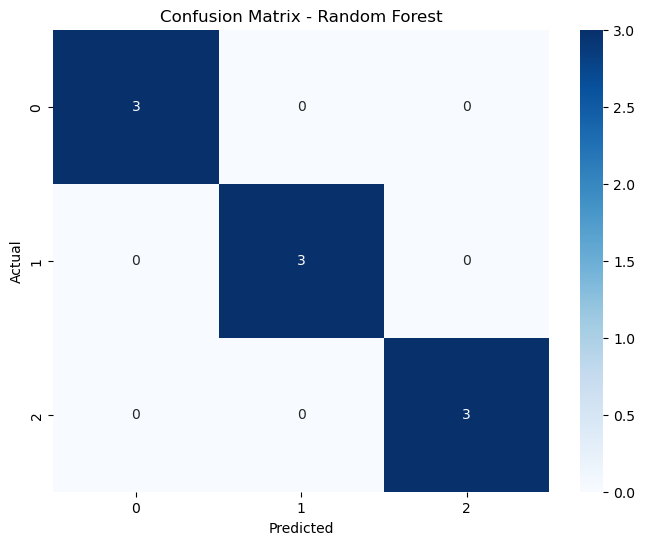

Random Forest shap_values shape is (27, 3, 3)
Selected SHAP values shape: (27, 3)


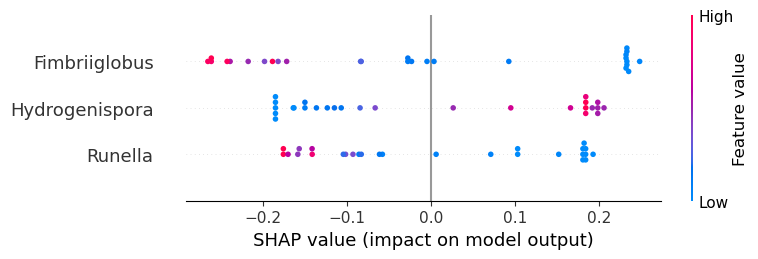

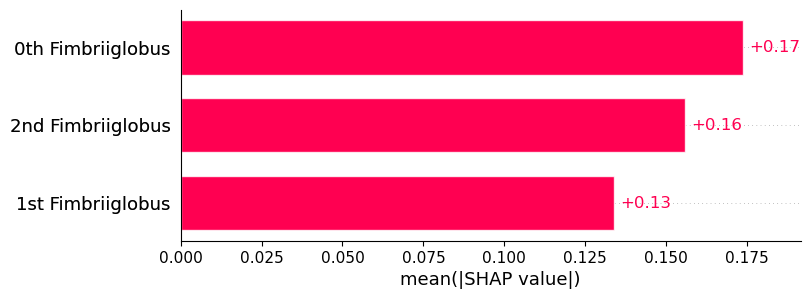

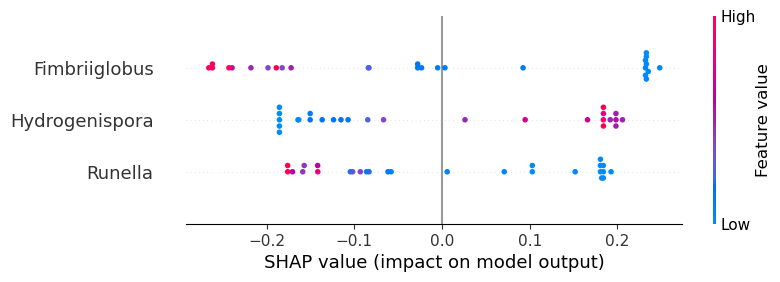

Model classes: [0 1 2]


In [324]:
# Hyperparameter Tuning and Cross-Validation for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
# Set a random_state for reproducibility
random_state = 42
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest:", best_params_rf)

# Print Cross-Validation Scores from GridSearchCV
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
print("\nCross-Validation Scores from GridSearchCV:\n", cv_results_rf[['mean_test_score', 'std_test_score', 'params']])

# Initialize the best Random Forest model
rf_model = RandomForestClassifier(**best_params_rf,random_state=random_state)

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation for Random Forest
print("\nRandom Forest - Test Set Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_rf))

# make sure the labels match
print("Unique values in y_test:", np.unique(y_test))

# Confusion Matrix
class_labels = rf_model.classes_
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SHAP Analysis, on train set. Use the following codes only for "Autoclave" and "Heat root" that have binary values
# Use TreeExplainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)

# Calculate SHAP values
shap_values_rf = explainer_rf.shap_values(X_train)
print("Random Forest shap_values shape is", np.shape(shap_values_rf))

# Select the SHAP values for the positive class (class 1/yes)
shap_values_rf_selected = shap_values_rf[:, :, 1]
# Print the shape of the resulting array
print("Selected SHAP values shape:", shap_values_rf_selected.shape)

# Create an Explanation object
shap_values_rf_explanation = shap.Explanation(
    shap_values_rf_selected,
    base_values=explainer_rf.expected_value[1],  # Use the expected value of the positive class
    data=X_train,
    # feature_names=feature_names
    feature_names=feature_names_reduced
)

# Generate SHAP plots for the Train set
# Summary Plot
# shap.summary_plot(shap_values_rf_explanation, X_train, feature_names=feature_names)
shap.summary_plot(shap_values_rf_explanation, X_train, feature_names=feature_names_reduced)
# Bar Plot
shap.plots.bar(shap_values_rf_explanation)

# Beeswarm Plot
shap.plots.beeswarm(shap_values_rf_explanation)

# # Waterfall Plot for the first instance
# shap.plots.waterfall(shap_values_rf_explanation[0])

print("Model classes:", rf_model.classes_)

#### SHAP Plot. Use the following cell when "Soil" is the intended label, which has 3 values ---> For RandomForest

In [96]:
# # Use TreeExplainer for Random Forest, on the train set
# explainer_rf = shap.TreeExplainer(rf_model)
# # Calculate SHAP values
# # shap_values_rf = explainer_rf.shap_values(X_test)
# shap_values_rf = explainer_rf.shap_values(X_train)
# print("Random Forest shap_values shape is", np.shape(shap_values_rf))

# # Ensure X_train is an array
# X_train_array = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
# print(X_train_array)
# # Check the shape of shap_values_rf
# print("SHAP values shape:", shap_values_rf.shape)

# # Generate all SHAP plots for each class
# for i in range(shap_values_rf.shape[2]):
#     print(f"Generating SHAP plots for Class: {le.classes_[i]}")

#     # Ensure the shapes match for the summary plot
#     class_shap_values = shap_values_rf[:, :, i]
    
#     # Create an Explanation object for the current class
#     shap_explanation = shap.Explanation(
#         values=class_shap_values,  # SHAP values for class i
#         base_values=explainer_rf.expected_value[i],  # Base values for class i
#         # data=X_test_array,
#         data=X_train_array,
#         feature_names=feature_names_reduced
#         # feature_names=feature_names
#     )

#     # Summary Plot
#     # shap.summary_plot(shap_explanation,X_train_array, feature_names=feature_names, class_names=le.classes_)
#     shap.summary_plot(shap_explanation, X_train_array, feature_names=feature_names_reduced, class_names=le.classes_)

#     # Bar Plot
#     shap.plots.bar(shap_explanation, max_display=10)

#     # Beeswarm Plot
#     shap.plots.beeswarm(shap_explanation)

#     # # Waterfall Plot for the first instance
#     # shap.plots.waterfall(shap_explanation[0])



#### LSVM Classifier

In [183]:
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 30],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto']  # relevant for RBF
}
random_state = 42

# Grid search with 5-fold CV
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=random_state),
                               param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

best_params_svm = grid_search_svm.best_params_
print("Best parameters for SVM:", best_params_svm)

# Cross-validation results
cv_results_svm = pd.DataFrame(grid_search_svm.cv_results_)
print("\nCross-Validation Scores from GridSearchCV:\n", cv_results_svm[['mean_test_score', 'std_test_score', 'params']])

# Train best model on full training set
model_svm = SVC(**best_params_svm, probability=True, random_state=random_state,max_iter=10000)
model_svm.fit(X_train, y_train)


# Predictions on test set
y_pred_svm = model_svm.predict(X_test)

# Standard prediction evaluation
print("\nStandard SVM - Test Set Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for SVM predictions
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["+N+Fe", "+N-Fe"], yticklabels=["+N+Fe", "+N-Fe"])
plt.title("Confusion Matrix - Standard SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ### Here, we apply SHAP ###
# Select the appropriate explainer
# SHAP explainer setup
if best_params_svm['kernel'] == 'linear':
    explainer_svm = shap.LinearExplainer(model_svm, X_train)
    shap_values_svm = explainer_svm.shap_values(X_train)
    base_values_svm = np.full(shap_values_svm.shape[0], explainer_svm.expected_value)
    expl_svm = shap.Explanation(
        shap_values_svm,
        base_values=base_values_svm,
        data=X_train,
        # feature_names=feature_names
        feature_names=feature_names_reduced
    )
else:
    def svm_proba(X):
        return model_svm.predict_proba(X)
    background = shap.sample(X_train, 100)
    explainer_svm = shap.KernelExplainer(svm_proba, background)
    shap_values_svm = explainer_svm.shap_values(X_train, nsamples=100)

    # Combine per-instance explanations for one class (e.g. class 1)
    shap_matrix = np.array([row[:,1] for row in shap_values_svm])
    base_values_svm = np.full(shap_matrix.shape[0], explainer_svm.expected_value[1])
    expl_svm = shap.Explanation(
        shap_matrix,
        base_values=base_values_svm,
        data=X_train,
        # feature_names=feature_names
        feature_names=feature_names_reduced
    )

# 🧠 SHAP visualizations
# shap.summary_plot(expl_svm.values, X_train, feature_names=feature_names,max_display=20)
shap.summary_plot(expl_svm.values, X_train, feature_names=feature_names_reduced,max_display=20)
shap.plots.bar(expl_svm, max_display=10)
shap.plots.beeswarm(expl_svm)
# # shap.plots.waterfall(expl_svm[1])

#### SHAP Plot. Use the following cell when "Soil" is the intended label, which has 3 values ---> For LSVM

In [145]:
# # Use TreeExplainer for Random Forest, on the train set
# explainer_svm = shap.LinearExplainer(model_svm, X_train)
# # Calculate SHAP values
# # shap_values_svm = explainer_svm.shap_values(X_test)
# shap_values_svm = explainer_svm.shap_values(X_train)
# print("SVM shap_values shape is", np.shape(shap_values_svm)) 

# # Ensure X_train is an array
# X_train_array = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
# print(X_train_array)
# # Check the shape of shap_values_svm
# print("SHAP values shape:", shap_values_svm.shape)

# # Generate all SHAP plots for each class
# for i in range(shap_values_svm.shape[2]):
#     print(f"Generating SHAP plots for Class: {le.classes_[i]}")

#     # Ensure the shapes match for the summary plot
#     class_shap_values = shap_values_svm[:, :, i]
    
#     # Create an Explanation object for the current class
#     shap_explanation = shap.Explanation(
#         values=class_shap_values,  # SHAP values for class i
#         base_values=explainer_svm.expected_value[i],  # Base values for class i
#         # data=X_test_array,
#         data=X_train_array,
#         feature_names=feature_names_reduced
#         # feature_names=feature_names
#     )

#     # Summary Plot
#     # shap.summary_plot(shap_explanation,X_train_array, feature_names=feature_names, class_names=le.classes_)
#     shap.summary_plot(shap_explanation, X_train_array, feature_names=feature_names_reduced, class_names=le.classes_)

#     # Bar Plot
#     shap.plots.bar(shap_explanation, max_display=10)

#     # Beeswarm Plot
#     shap.plots.beeswarm(shap_explanation)

#     # # Waterfall Plot for the first instance
#     # shap.plots.waterfall(shap_explanation[0])


### ShapG

In [13]:
# important libraries
# # import shapG and necessary libraries
# import networkx as nx
# from sklearn.metrics import mutual_info_score
# from sklearn.feature_selection import mutual_info_regression
# from scipy.stats import pearsonr,kendalltau,spearmanr
# import sys
# import os
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))
# import shapG.shapley as shapley
# import shapG.plot as shapGplot
# from shapG.utils import corr_generator, create_minimal_edge_graph, matrix_generator, kl, kl_mi_matrix
# import lightgbm as lgb
# # from sklearn.metrics import r2_score
# from sklearn.metrics import f1_score

#### SHAPG for LSVM

#### Binary state

In [146]:
# X_train_df = pd.DataFrame(X_train, columns=X.columns)

# # --- NEW: SHAPG Analysis on the Training Set Only ---

# # Step 1: Build the similarity matrix (and graph) using only the training data.
# # This means we only capture feature relationships as seen on X_train.
# W = matrix_generator(X_train_df, kl)
# A, W_new = create_minimal_edge_graph(W, reverse=True, version='v3')
# G = nx.Graph(A)

# # Step 2: Redefine the characteristic function to use only the training set.
# # Here we use an internal train/validation split on X_train & y_train 
# # to evaluate the performance of each feature subset.

# def classification_kpi(G, S):
#     """
#     Characteristic function for SHAPG XAI on the training set.
#     It splits X_train (only the selected columns) into an inner train/validation,
#     trains a logistic regression model (using your tuned hyperparameters),
#     and returns the evaluation score (F1 score) on the validation set.
    
#     Args:
#         G (nx.Graph): The feature graph (not directly used in the function).
#         S (list): A list of feature names (columns) in X_train.
    
#     Returns:
#         float: The F1 score for the model trained on the subset S.
#     """
#     cols = list(S)
#     if len(cols) == 0:
#         return 0
#     else:
#         # Internal split on training data only:
#         X_train_sub, X_val, y_train_sub, y_val = train_test_split(
#             X_train_df[cols], y_train, test_size=0.2, random_state=42
#         )
#         # Use a fixed logistic regression with your best-tuned parameters:
#         model_kpi = SVC(**best_params_svm, probability=True, random_state=random_state)
#         # model_kpi = LogisticRegression(**best_params_lr, max_iter=5000, tol=1e-3, random_state=random_state)
#         model_kpi.fit(X_train_sub, y_train_sub)
#         y_pred = model_kpi.predict(X_val)
#         # For binary or multi-class classification, choose the appropriate averaging.
#         score = f1_score(y_val, y_pred, average='binary')
#         return score

# # Step 3: Run the SHAPG algorithm using the feature graph G and your new KPI function.
# shapley_value = shapley.shapG(G, m=3, f=classification_kpi, approximate_by_ratio=False)

# # Step 4: Visualize the SHAPG results.
# fig, ax = shapGplot(shapley_value, top_n=20, show_plot=False)
# ax.set_xlabel("Feature importance", fontsize=14)
# ax.set_ylabel("Features", fontsize=14)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_title('Top 20 Influential Features (SHAPG on Training Set)', fontsize=16)
# plt.show()


#### Multiclass state

In [14]:
# for class_label in np.unique(y_train):
#     print(f"\n🔍 Running SHAPG for class: {le.classes_[class_label]}")

#     # Create binary labels: 1 for current class, 0 for others
#     y_binary = (y_train == class_label).astype(int)

#     def classification_kpi(G, S):
#         cols = list(S)
#         if len(cols) == 0:
#             return 0
#         else:
#             X_train_sub, X_val, y_train_sub, y_val = train_test_split(
#                 X_train_df[cols], y_binary, test_size=0.2, random_state=42
#             )
#             model_kpi = SVC(**best_params_svm, probability=True, random_state=random_state)
#             model_kpi.fit(X_train_sub, y_train_sub)
#             y_pred = model_kpi.predict(X_val)
#             score = f1_score(y_val, y_pred, average='binary')
#             return score

#     # Run SHAPG for this binary setup
#     shapley_value = shapley.shapG(G, m=3, f=classification_kpi, approximate_by_ratio=False)

#     # Plot results
#     fig, ax = shapGplot(shapley_value, top_n=20, show_plot=False)
#     ax.set_xlabel("Feature importance", fontsize=14)
#     ax.set_ylabel("Features", fontsize=14)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_title(f'Top Features for Class: {le.classes_[class_label]} (SHAPG)', fontsize=16)
#     plt.show()
